# Adding a discharge point source to a LEM

*(Greg Tucker, CSDMS / CU Boulder, fall 2020)*

This notebook shows how to add one or more discharge point sources to a Landlab-built landscape evolution model (LEM), using the flow routing components. The basic idea is to modify the `water__unit_flux_in` field to include a large flux (which could be represented as either drainage area or discharge) at one or more locations along the edge of a grid.

In [1]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import FlowAccumulator
import numpy as np

## Docstring example from `FlowAccumulator`

The following is a tiny example from the `FlowAccumulator` documentation:

In [2]:
mg = RasterModelGrid((5, 4), xy_spacing=(10., 10))

topographic__elevation = np.array([0.,  0.,  0., 0.,
                                   0., 21., 10., 0.,
                                   0., 31., 20., 0.,
                                   0., 32., 30., 0.,
                                   0.,  0.,  0., 0.])

_ = mg.add_field("topographic__elevation", topographic__elevation, at="node")
mg.set_closed_boundaries_at_grid_edges(True, True, True, False)
fa = FlowAccumulator(
     mg,
     'topographic__elevation',
     flow_director='FlowDirectorSteepest'
     )
runoff_rate = np.arange(mg.number_of_nodes, dtype=float)
rnff = mg.add_field("water__unit_flux_in", runoff_rate, at="node", clobber=True)
fa.run_one_step()
print(mg.at_node['surface_water__discharge'].reshape(5, 4)) 
#    array([    0.,   500.,  5200.,     0.,
#               0.,   500.,  5200.,     0.,
#               0.,   900.,  4600.,     0.,
#               0.,  1300.,  2700.,     0.,
#               0.,     0.,     0.,     0.])


[[    0.   500.  5200.     0.]
 [    0.   500.  5200.     0.]
 [    0.   900.  4600.     0.]
 [    0.  1300.  2700.     0.]
 [    0.     0.     0.     0.]]


We can extend this tiny example to show that you can subsequently modify the `rnff` array and it will take effect when you re-run the `FlowAccumulator`:

In [3]:
rnff[:] = 1.0
fa.run_one_step()
print(mg.at_node['surface_water__discharge'].reshape(5, 4))

[[   0.  100.  500.    0.]
 [   0.  100.  500.    0.]
 [   0.  100.  400.    0.]
 [   0.  100.  200.    0.]
 [   0.    0.    0.    0.]]


## Larger example

In this example, we create a slightly larger grid, with a surface that slopes down toward the south / bottom boundary. We will introduce a runoff point source at a node in the middle of the top-most non-boundary row.

Start by defining some parameters:

In [4]:
# Parameters
nrows = 41
ncols = 41
dx = 100.0 # grid spacing in m
slope_gradient = 0.01 # gradient of topographic surface
noise_amplitude = 0.2 # amplitude of random noise
input_runoff = 10000.0 # equivalent to a drainage area of 10,000 dx^2 or 10^8 m2

Create grid and topography, and set boundaries:

In [5]:
# Create a grid, and a field for water input
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)

# Have just one edge (south / bottom) be open
grid.set_closed_boundaries_at_grid_edges(True, True, True, False)

# Create an elevation field as a ramp with random noise
topo = grid.add_zeros('topographic__elevation', at='node')
topo[:] = slope_gradient * grid.y_of_node
np.random.seed(0)
topo[grid.core_nodes] += noise_amplitude * np.random.randn(grid.number_of_core_nodes)

The `FlowAccumulator` component takes care of identifying drainage directions (here using the D8 method) and calculating the cumulative drainage area and surface water discharge.

Note that in this case we are assuming a default runoff value of unity, meaning that the calculated `surface_water__discharge` is actually just drainage area. To introduce the drainage area of a river entering at the top, we will use a large value for runoff. Because we are considering drainage area as the primary variable, with unit "runoff", our input runoff is a dimensionless variable: the number of contributing grid cell equivalents. We will set this to unity at all the nodes in the model except the point-source location.

In [6]:
# Create a FlowAccumulator component
fa = FlowAccumulator(grid, flow_director='FlowDirectorD8')

In [7]:
# Create a runoff input field, and set one of its nodes to have a large input
runoff = grid.add_ones('water__unit_flux_in', at='node', clobber=True)
top_middle_node = grid.number_of_nodes - int(1.5 * ncols)
runoff[top_middle_node] = input_runoff

In [8]:
fa.run_one_step()

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


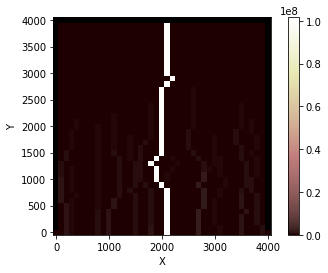

In [9]:
imshow_grid(grid, 'surface_water__discharge')

## Changing the amount and/or location of input

We can change the input drainage area / discharge amount or location simply by modifying the `water__unit_flux_in` field. Here we will shift it to the left and double its magnitude.

In [10]:
runoff[top_middle_node] = 1.0 # go back to being a "regular" node
runoff[top_middle_node - 15] = 2 * input_runoff # shift 15 cells left and double amount
fa.run_one_step()

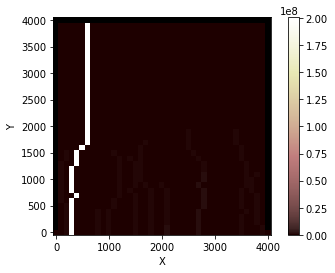

In [11]:
imshow_grid(grid, 'surface_water__discharge')

Note that the `drainage_area` field does not recognize any runoff input. It continues to track *only* the local drainage area:

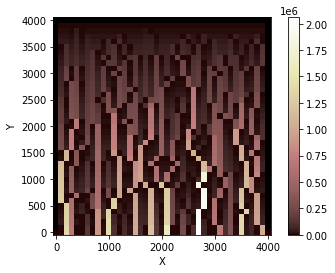

In [12]:
imshow_grid(grid, 'drainage_area')

This means that you should use the `surface_water__discharge` field rather than the `drainage_area` field, regardless of whether the former is meant to represent discharge (volume per time) or effective drainage area (area).

## Combining with a Landscape Evolution Model

Here we'll set up a simple LEM that uses the river input.

In [13]:
from landlab.components import StreamPowerEroder, LinearDiffuser

In [14]:
# Parameters
K = 4.0e-5
D = 0.01
uplift_rate = 0.0001
nrows = 51
ncols = 51
dx = 10.0 # grid spacing in m
slope_gradient = 0.01 # gradient of topographic surface
noise_amplitude = 0.04 # amplitude of random noise
input_runoff = 10000.0 # equivalent to a drainage area of 10,000 dx^2 or 10^6 m2
run_duration = 25.0 / uplift_rate

dt = dx / (K * (dx * dx * input_runoff)**0.5)
num_steps = int(run_duration / dt)
print(str(num_steps) + ' steps.')

1000 steps.


In [15]:
# Create a grid, and a field for water input
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)

# Have just one edge (south / bottom) be open
grid.set_closed_boundaries_at_grid_edges(True, True, True, False)

# Create an elevation field as a ramp with random noise
topo = grid.add_zeros('topographic__elevation', at='node')
topo[:] = slope_gradient * grid.y_of_node
np.random.seed(0)
topo[grid.core_nodes] += noise_amplitude * np.random.randn(grid.number_of_core_nodes)

# Create components
fa = FlowAccumulator(grid, flow_director='FlowDirectorD8')
sp = StreamPowerEroder(grid, K_sp=K, discharge_field='surface_water__discharge')
ld = LinearDiffuser(grid, linear_diffusivity=D)

In [16]:
runoff = grid.add_ones('water__unit_flux_in', at='node', clobber=True)
top_middle_node = grid.number_of_nodes - int(1.5 * ncols)
runoff[top_middle_node] = input_runoff

In [17]:
for _ in range(num_steps):
    topo[grid.core_nodes] += uplift_rate * dt
    fa.run_one_step()
    ld.run_one_step(dt)
    sp.run_one_step(dt)

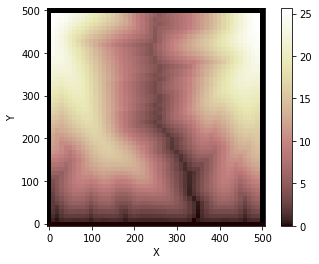

In [18]:
imshow_grid(grid, topo)